In [1]:
from google.cloud import bigquery
bq = bigquery.Client()

In [2]:
q = bq.query(
"""
select count(*) as num_rows 
from bigquery-public-data.geo_us_boundaries.counties
""")
q.to_dataframe()

,num_rows
0,3233


In [3]:
#q1
q = bq.query(
"""
select *
from bigquery-public-data.geo_us_boundaries.counties
WHERE county_name = 'Dane'
""")
result = q.to_dataframe()["geo_id"][0]
result

'55025'

In [4]:
#q2
q = bq.query(
"""
select state_fips_code, count(*) as num_counties
from bigquery-public-data.geo_us_boundaries.counties
GROUP BY state_fips_code
ORDER BY num_counties DESC
LIMIT 5
""")

result = q.to_dataframe()
top_states_dict = {}

for index, row in result.iterrows():
    state_code = row['state_fips_code']
    num_counties = row['num_counties']
    top_states_dict[state_code] = num_counties

top_states_dict

{'48': 254, '13': 159, '51': 133, '21': 120, '29': 115}

In [5]:
#q3

from google.cloud import bigquery

bq_cost = bigquery.Client()

iowa_cost = 6.25  # Replace this with the actual cost for your region

# Query 1
q1_job_config = bigquery.QueryJobConfig(use_query_cache=False)
q1_query = """
SELECT *
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE county_name = 'Dane'
"""
q1_job = bq_cost.query(q1_query, job_config=q1_job_config)
q1_job_result = q1_job.result()
q1_cost = q1_job.total_bytes_billed / 1024**4 * iowa_cost

# Query 2
q2_job_config = bigquery.QueryJobConfig(use_query_cache=False)
q2_query = """
SELECT state_fips_code, COUNT(*) AS num_counties
FROM bigquery-public-data.geo_us_boundaries.counties
GROUP BY state_fips_code
ORDER BY num_counties DESC
LIMIT 5
"""
q2_job = bq_cost.query(q2_query, job_config=q2_job_config)
q2_job_result = q2_job.result()
q2_cost = q2_job.total_bytes_billed / 1024**4 * iowa_cost

cost_dict = {'q1': q1_cost, 'q2': q2_cost}

cost_dict

{'q1': 0.0010907649993896484, 'q2': 5.9604644775390625e-05}

In [6]:
#!wget https://pages.cs.wisc.edu/~harter/cs544/data/hdma-wi-2021.parquet

In [7]:
from google.cloud.bigquery import LoadJobConfig
project_id = 'silent-bird-398316'
bucket_name = 'cs544eyyp8'
dataset_id = 'p8'
table_id = "hdma"


ds = bigquery.Dataset(project_id+"."+dataset_id)

dataset_ref = bq.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)
existing_table = bq.get_table(table_ref)

# If the table exists, delete it
if existing_table:
    bq.delete_table(table_ref)

bq.create_dataset(ds, exists_ok=True)
dataset_ref = bq.dataset(dataset_id)

gcs_uri = f"gs://{bucket_name}/hdma-wi-2021.parquet"

job_config = LoadJobConfig(
    source_format=bigquery.SourceFormat.PARQUET,
)

load_job = bq.load_table_from_uri(gcs_uri, dataset_ref.table(table_id), job_config=job_config)

load_job.result()
print(f"Parquet data loaded into BigQuery table: {project_id}.{dataset_id}.{table_id}")

Parquet data loaded into BigQuery table: silent-bird-398316.p8.hdma


In [8]:
#q4

[ds.dataset_id for ds in bq.list_datasets(project_id)]

['p8']

In [9]:
dataset_ref = bq.dataset(dataset_id)

# List tables in the dataset
tables = list(bq.list_tables(dataset_ref))
for table in tables:
    print(f"Table ID: {table.table_id}")


Table ID: applications
Table ID: applications_with_loan_term
Table ID: hdma
Table ID: houses
Table ID: wi


In [10]:
#q5

df = bq.query("""
SELECT c.county_name, COUNT(*) AS count
FROM p8.hdma h
LEFT JOIN bigquery-public-data.geo_us_boundaries.counties c ON c.county_fips_code = h.county_code
GROUP BY c.county_name
ORDER BY count DESC
LIMIT 10
""")

result = df.to_dataframe()

top_loans_dict = {}

for index, row in result.iterrows():
    county_name = row['county_name']
    count = row['count']
    top_loans_dict[county_name] = count

top_loans_dict

{'Milwaukee': 46570,
 'Dane': 38557,
 'Waukesha': 34159,
 'Brown': 15615,
 'Racine': 13007,
 'Outagamie': 11523,
 'Kenosha': 10744,
 'Washington': 10726,
 'Rock': 9834,
 'Winnebago': 9310}

In [11]:
from google.cloud import bigquery

project_id = "silent-bird-398316"  # Replace with your GCP project ID
dataset_id = "p8"  # Replace with your dataset ID
table_id = "applications"

sheets_url = "https://docs.google.com/spreadsheets/d/11UeIBqQylAyNUBsIO54p6WiYJWHayQMfHDbUWq1jGco/"

bq = bigquery.Client(project=project_id)

dataset_ref = bq.dataset(dataset_id)

table_ref = dataset_ref.table(table_id)
existing_table = bq.get_table(table_ref)

# If the table exists, delete it
if existing_table:
    bq.delete_table(table_ref)

external_config = bigquery.ExternalConfig("GOOGLE_SHEETS")
external_config.source_uris = [sheets_url]
external_config.options.skip_leading_rows = 1
external_config.autodetect = True

table_ref = dataset_ref.table(table_id)
table = bigquery.Table(table_ref)
table.external_data_configuration = external_config

table = bq.create_table(table, exists_ok=True)

print(f"External table '{table_id}' added to BigQuery.")


External table 'applications' added to BigQuery.


In [12]:
#q6

chosen_income = 100000
df = bq.query("""
SELECT COUNT(*) AS count
FROM p8.applications a
WHERE income = 100000
""")

count = df.to_dataframe()["count"][0]
count

6

In [13]:
# !pip install geopandas

In [14]:
# get our copy of just WI
df = bq.query("""
CREATE OR REPLACE TABLE `silent-bird-398316.p8.wi`
AS
SELECT county_name, county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55'
""").to_geodataframe()

df = bq.query("SELECT * FROM p8.wi").to_geodataframe()

df.head(3)

,county_name,county_geom
0,Jackson,"POLYGON ((-91.16601 44.33510, -91.16600 44.333..."
1,Iron,"POLYGON ((-90.54885 46.41383, -90.54885 46.413..."
2,Douglas,"POLYGON ((-92.20188 46.65877, -92.20175 46.657..."


In [15]:
bq.query("""
CREATE OR REPLACE TABLE p8.houses
AS
SELECT *, ST_GEOGPOINT(longitude, latitude) as loc
FROM p8.applications
""").to_geodataframe()

""


In [16]:
#q7

wi_houses = bq.query("""
SELECT wi.county_name, COUNT(*) AS count
FROM `silent-bird-398316.p8.houses` AS houses
CROSS JOIN `silent-bird-398316.p8.wi` AS wi
WHERE ST_Within(houses.loc, wi.county_geom)
GROUP BY wi.county_name
""").to_dataframe()

counties_houses_dict = {}

for index, row in wi_houses.iterrows():
    county_name = row['county_name']
    count = row['count']
    counties_houses_dict[county_name] = count

counties_houses_dict

{'Barron': 2,
 'Green Lake': 1,
 'Bayfield': 1,
 'Marinette': 2,
 'Monroe': 1,
 'Jefferson': 1,
 'Door': 4,
 'Outagamie': 1,
 'Dane': 8,
 'Columbia': 1,
 'Sauk': 1,
 'Kewaunee': 1,
 'Oneida': 1,
 'Sheboygan': 2,
 'Brown': 2,
 'Walworth': 2}

<Axes: >

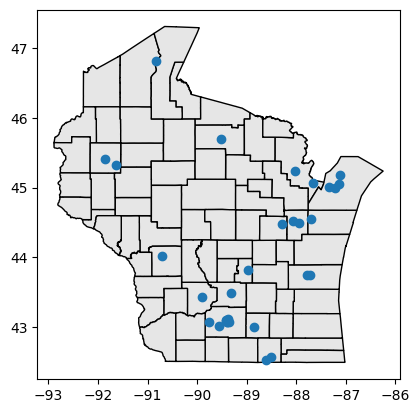

In [17]:
plot_houses = bq.query("""
SELECT houses.loc
FROM `silent-bird-398316.p8.houses` AS houses
CROSS JOIN `silent-bird-398316.p8.wi` AS wi
WHERE ST_Within(houses.loc, wi.county_geom)
""").to_geodataframe()

ax = bq.query("SELECT county_geom FROM p8.wi").to_geodataframe().plot(color="0.9", edgecolor="k")
plot_houses.plot(ax=ax)

In [18]:
%load_ext google.cloud.bigquery

In [19]:
%%bigquery
CREATE OR REPLACE MODEL `silent-bird-398316.p8.model`
OPTIONS(MODEL_TYPE='LINEAR_REG',
 INPUT_LABEL_COLS=['loan_amount'])
AS
SELECT income, loan_term, loan_amount
FROM p8.hdma

Query is running:   0%|          |

""


In [20]:
#q8

evaluate = bq.query("""
SELECT *
FROM
  ML.EVALUATE(MODEL `silent-bird-398316.p8.model`,
    (
    SELECT income, loan_term, loan_amount
    FROM p8.hdma
    )
  )
""").to_dataframe()

evaluate.at[0,"r2_score"]

0.2916541228801983

In [21]:
#q9

weight = bq.query("""
SELECT *
FROM ML.WEIGHTS(MODEL `silent-bird-398316.p8.model`)
""").to_dataframe()

income_weight = weight[weight['processed_input'] == 'income']['weight'].values[0]
income_weight

0.8057773037176396

In [22]:
bq.query("""
CREATE OR REPLACE TABLE p8.applications_with_loan_term
AS
SELECT *, 360 AS loan_term
FROM p8.applications
""")

QueryJob<project=silent-bird-398316, location=US, id=a808a456-7729-4f94-8feb-9175d0f6ec2a>

In [23]:
#q10

predict = bq.query("""
SELECT *
FROM ML.PREDICT(MODEL `silent-bird-398316.p8.model`,
    (
    SELECT income, loan_term, loan_amount
    FROM p8.applications_with_loan_term
    )
  )
""").to_dataframe()

exceed = 0
total = 0
for index, row in predict.iterrows():
    total += 1
    if row["loan_amount"] > row["predicted_loan_amount"]:
        exceed += 1

ratio = exceed/total
ratio

0.6666666666666666